# Начальные модули

In [1]:
import numpy as np
import pandas as pd
import random
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.cuda.memory import list_gpu_processes
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import os
import re
import pandas as pd

In [2]:
#подключение ГПУ
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#для репитативности результатов
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

cuda


In [3]:
#отключение предупреждений
import warnings 
warnings.filterwarnings('ignore')

In [4]:
class customdataset (Dataset):
    def __init__ (self, profile, group, name):
        self.profile = torch.FloatTensor(profile)
        self.group = group
        self.name = name
        
    def __len__ (self):
        return int(self.profile.size(dim = 0))
    
    def __getitem__ (self, index):
        profile = self.profile[index, :]
        name = self.name[index]
        group = self.group[index]
        return{'profile': profile,
            'group': group,
            'ID': name}
    def cat (self, profile, group, name):
        self.profile = torch.cat((self.profile, profile), 0)
        self.group[len(self.group):] = group
        self.name[len(self.name):] = name
        
class vanilla_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(12001, 6000),
            nn.ReLU(),
            #nn.Dropout(p=0.25),
            nn.Linear(6000, 750),
            nn.ReLU(),
            nn.Linear(750, 50)
            )
        
        self.unfc = nn.Linear(50, 750)
        
        self.decoder = nn.Sequential(
        nn.ReLU(), 
        nn.Linear(750, 6000),
        #nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.Linear(6000, 12001)
        )
              
    def forward(self, x):
        x = self.encoder(x)
        embadding = x.copy()
        x = self.unfc(embadding)
        reconstruction = self.decoder(x)

        return reconstruction, embadding  
    
def ERA_loss(rec, real, emb):
    def euclid (x):
        x = x**2
        l = torch.sum(x)
        l = torch.sqrt(l)
        return l
    len_sum=0
    for i in range(real.size(dim=0)):
        for j in range(i + 1, real.size(dim=0)):
            len_real = euclid(real[i, :(len(real[0]) - 1)]-real[j, :(len(real[0]) - 1)])
            len_emb = euclid(emb[i, :(len(real[0]) - 1)]-emb[j, :(len(real[0]) - 1)])
            len_sum = len_sum + (len_real - len_emb)**2
    len_sum=len_sum+F.mse_loss(rec, real)
    return len_sum       


In [5]:
class Bionet:
    def __init__(self):
        self._get_data()
        self.forests = pd.DataFrame(columns = ['group', 'ID'], index = [0], dtype = object)
        dirs = [r'C:\education\ML\MS_profiles\sets',\
               r'C:\education\ML\networks',\
               r'C:\education\ML\forests\group',\
               r'C:\education\ML\forests\ID']

        # Get all filenames in each directory
        all_files = [os.listdir(dir_) for dir_ in dirs]
        names =['set_group_distribution', 'DAE_noise', 'RF_group', 'RF_ID'] 
        
        if (all_files[0] == [])and(all_files[1] == [])and(all_files[2] == [])and(all_files[3] == []):
            self.paths = pd.DataFrame(index=names, columns=[-1], dtype=object)
            return None

        # Regular expression to extract the number from the file name
        pattern = re.compile(r'(.+)_(\d+)%')
        
        all_filtred_files = []
        all_unique_numbers = []
        
        for i in range(4):
            all_filtred_files.append([filename for filename in all_files[i] if pattern.search(filename)])
            for filename in set(all_files[i]) - set(all_filtred_files[i]):
                print(f"No match found for: {filename}")
            all_unique_numbers.append(sorted({int(pattern.search(filename).group(2)) for filename in all_filtred_files[i]}))

        # Combine the unique numbers and create the columns for the DataFrame
        total_all_unique_numbers = sorted(list(set(all_unique_numbers[0]).union(set(all_unique_numbers[1]), set(all_unique_numbers[2]), set(all_unique_numbers[3]))))

        # Initialize the DataFrame with NaN values
        self.paths = pd.DataFrame(index=names, columns=total_all_unique_numbers, dtype=object)

        # Populate the DataFrame with file paths from the first directory
        for i in range(4):
            for filename in all_filtred_files[i]:
                number = int(pattern.search(filename).group(2))
                file_path = os.path.join(dirs[i], filename)
                self.paths.at[names[i], number] = file_path
        return None

        
    def _get_data(self) -> None:
        #считали ключи (название файла - бактерия)
        #read keys (file name - bacil)
        profiles_ID = pd.read_csv(r'C:\education\ML\MS_profiles\profiles_group_ID.csv', sep=';', header=None)
        t = pd.read_csv(r'C:\education\ML\MS_profiles\0a2c8dcb-9e19-47a4-9f35-0d7a5728eaa7', sep=';', index_col=0, header=None)
        t = t.T
        t[15001.0] = 0

        # пустой словарь для удобного считывания 
        self.original_profiles = pd.DataFrame({k: pd.Series(dtype=float) for k in t.columns})

        #считываем каждый файл
        for i in profiles_ID.index:
            path = os.path.join(r'C:\education\ML\MS_profiles', profiles_ID.at[i, 0])
            s = pd.read_csv(path, sep=';', index_col=0, header=None)
            s = s.T
            s[15001.0] = profiles_ID.at[i, 1]
            s[15002.0] = profiles_ID.at[i, 2]
            self.original_profiles = self.original_profiles.append(s)

        #делаем красивые индексы
        self.original_profiles.index = profiles_ID.index
        
        self.original_profiles = customdataset (self.original_profiles.iloc[:, :12001].to_numpy(),\
                                            self.original_profiles.iloc[:, 12001].to_numpy(),\
                                            self.original_profiles.iloc[:, 12002].to_numpy())
        return None
    
    
    def inference_noise(self,
                        noise: int = 40,
                        amount_additional_profiles: int = 200) -> None:
        self.paths.at['set_group_distribution', noise] = r'C:\education\ML\MS_profiles\sets\set_group_\
                                                              distribution_'+str(noise)+'%.csv'
        noise_factor = noise/100
        for n, i in tqdm (enumerate(pd.unique(self.original_profiles[15002.0]))):
            s = self.original_profiles.loc[self.original_profiles[15002.0] == i].copy()
            s.index = {j for j in range (len(s.index))}#красивые индексы   
            s = s.sample()
            s = s.to_numpy()[0]
            main = s.copy()
            for m, j in enumerate(range(amount_additional_profiles)):
                s = main.copy()
                tmp = s[:12001].astype(float)
                tmp = tmp + np.random.normal(loc=0.0,
                                             scale = noise_factor*tmp,
                                             size = (len(self.original_profiles.columns) - 2))#шумим
                tmp = abs(tmp)
                s[:12001] = tmp
                np.place(s[:12001], s[:12001] > 1, 1)
                if (m == 0)and(n == 0):
                    S = np.array([s])
                else:    
                    S = np.append(S, np.array([s]), axis = 0)
        MS_profiles_inference = pd.DataFrame(S, columns = MS_profiles.columns)
        MS_profiles_inference.index = {i for i in range(len(MS_profiles_inference.index))}
        path = r'C:\education\ML\MS_profiles\sets\set_group_distribution_'+str(noise)+'%.csv'
        MS_profiles_inference.to_csv(path, sep=';', header=True, index=True,)
        return None
    
    def load_set(self, noise: int):
        if (noise not in self.paths.columns):
            print(f"Error: There are not such set,\
                 please, train and save requied set\
                 with corresponding methods\
                from this class")
            return None
        
        set_path = self.paths.at['set_group_distribution', noise]
        
        if pd.isna(set_path):
            print(f"Error: There are not such set,\
                 please, train and save requied set\
                 with corresponding methods\
                from this class")
            return None
        raw_set = pd.read_csv(set_path, sep=';', index_col=0, header=0)
        raw_set = raw_set.astype({'15002.0': 'str'})
        self.set = customdataset(raw_set[:'15001'], raw_set[:, '15001'], raw_set[:, '15002'])
        return None
    
    def bootstrap(self,
                  noise: int,
                  attribute: str = 'group',
                  amoumt: int = 1000)-> None:
        
        self.load_net(noise = noise)
        self.load_set(noise = noise)
    
        self.get_embaddings()
        
        for i in tqdm(range(amoumt)):
            train_value, test_value = train_test_split(self.embaddings,
                                                       train_size=0.7,
                                                       shuffle=True)

            classifier_group = RandomForestClassifier()
            classifier_ID = RandomForestClassifier()
            classifier_group.fit(train_value[:]['profile'], train_value[:]['group'])
            classifier_ID.fit(train_value[:]['profile'],train_value[:]['ID'])
            pred_ID = classifier_ID.predict(test_value[:]['profile'])
            pred_group = classifier_group.predict(test_value[:]['profile'])
            accuracies_ID.append(accuracy_score(test_value[:]['ID'], pred_ID))
            accuracies_group.append(accuracy_score(train_value[:]['group'], pred_group))
            
        accuracies_ID = pd.Series(accuracies_ID)
        accuracies_group = pd.Series(accuracies_group)

        accuracies_ID.to_csv(rpath_ID, sep=';', header=True, index=True,)
        accuracies_group.to_csv(rpath_group, sep=';', header=True, index=True,)
        
        df = accuracies_group.to_numpy()
        fig = px.histogram(df,  marginal="box",\
                labels={'count':'amount of bootstraps', 'value':'accuracy'}, hover_data=df.transpose())
        fig.update_layout(showlegend=False)
        fig.show()
        
        fig.write_image(r'C:\education\ML\reports&results\bootstrap_'+attribute+'_'+str(noise)+'%.png')
        return None

def prepare_data (self, noise: int, batch_s: int = 16)-> None:
    
    #attentions
    if (noise not in self.paths.columns):
            print(f"Error: There are not such any object corresponding this level of noise,\
                 please, train and save requied object\
                 with corresponding methods\
                from this class")
            return None
        
    set_path = self.paths.at['set_group_distribution', noise]
    
    if pd.isna(forest_path):
            print(f"Error: There are not such set, please, create requied set\
                 with corresponding methods\
                from this class")
            return None
    
    inference_set = pd.read_csv(set_path, sep=';', index_col=0, header=0)
    inference_set = customdataset(inference_set.iloc[:, :12001].to_numpy(),
                                            inference_set.iloc[:, 12001].to_numpy(),
                                            inference_set.iloc[:, 12002].to_numpy())
    
    
    self.train_data = DataLoader(inference_set, batch_size=batch_s, shuffle=True)#а на train отправляем весь\
    return None

def train_one_set(self, n_epochs: int=50,
                        lr: float=0.001, 
                        noise_factor: float=40,
                        L=F.mse_loss) -> None:
    noise_factor = noise_factor/100
    self.autoencoder = vanilla_autoencoder().to(device)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    embaddings = torch.Tensor()
    truth = torch.Tensor()
    pred = torch.Tensor()

    for epoch in tqdm(range(n_epochs)): #tqdm для красивой загрузочки
        self.autoencoder.train()
        train_losses_per_epoch = []
        
        for X_batch in self.train_data:
            noise = X_batch['profile'] + \
            torch.FloatTensor(np.random.normal(loc=0.0, \
                    scale=noise_factor*X_batch['profile'], size= list(X_batch['profile'].size())))#шумим
            noise = torch.abs(noise)
            y = torch.ones(list(X_batch['profile'].size()))
            noise = torch.where(noise < 1, noise, y)
            
            X_batch['profile'] = X_batch['profile'].to(device)#чистые векторы 
            noise = noise.to(device)
            
            optimizer.zero_grad()
            reconstructed, embadding = self.autoencoder.forward(noise)#скармливаем шум
            loss = L(reconstructed, X_batch['profile'])#сравниваем с читыми
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        self.train_losses = train_losses

        self.autoencoder.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch in self.train_data:
                noise = X_batch['profile'] + \
                         torch.FloatTensor(np.random.normal(loc=0.0, \
                          scale=noise_factor*X_batch['profile'], size= list(X_batch['profile'].size())))#шумим
                noise = torch.abs(noise)
                y = torch.ones(list(X_batch['profile'].size()))
                noise = torch.where(noise < 1, noise, y)
                
                noise = noise.to(device)
                X_batch['profile'] = X_batch['profile'].to(device)
                
                reconstructed, embadding = self.autoencoder(noise)
                loss = L(reconstructed, X_batch['profile'])
                val_losses_per_epoch.append(loss.item())
                    
                embadding = embadding.to('cpu')
                reconstructed = reconstructed.to('cpu')
                X_batch['profile'] = X_batch['profile'].to('cpu')

                self.embaddings = customdataset(embadding, X_batch['group'].copy(), X_batch['ID'].copy())
                self.truth = customdataset(X_batch['profile'], X_batch['group'].copy(), X_batch['ID'].copy())
                self.pred = customdataset(reconstructed, X_batch['group'].copy(), X_batch['ID'].copy())
                

        val_losses.append(np.mean(val_losses_per_epoch))
        self.val_losses = val_losses
        return None
        
    def losses_plot(self, noise: str) -> None:
        plt.plot(self.train_losses, label="train_loss")
        plt.plot(self.val_losses, label="val_loss")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()
        plt.savefig(r'C:\education\ML\reports&results\loss_per_epoch_'+str(noise)+'%.png')
        return None
    
    def get_embaddings (self):
        raw_embaddings = self.autoencoder(self.set)
        self.embaddings = customdataset(raw_embaddings, self.set['group'].copy(), self.set['ID'].copy())
        return None
    
    def save_net(self, noise: int) -> None:
        self.paths.at['DAE_noise', noise] = r'C:\education\ML\networks\DAE_noise_'+str(noise)+'%.pkl'
        torch.save(self.autoencoder.encoder, r'C:\education\ML\networks\DAE_noise_'+str(noise)+'%.pkl')
        return None
    
    def load_net(self, noise: int) -> None:
        
        if (noise not in self.paths.columns):
            print(f"Error: There are not such network,\
                 please, train and save requied network\
                 with corresponding methods\
                from this class")
            return None
        
        model_path = self.paths.at['DAE_noise', noise]
        
        if pd.isna(model_path):
            print(f"Error: There are not such network,\
                 please, train and save requied network\
                 with corresponding methods\
                from this class")
            return None
        self.autoencocer = torch.load(model_path)
        return None
    
    def heat_map(self, noise: int, attribute: str='group') -> None: 
        if (attribute != 'group') or (attribute != 'ID'):
            print('Error: unexpectable attribute')
            return None
        
        
        
        def euclid (x):
            x = x**2
            l = np.sum(x)
            l = np.sqrt(l)
            return l
        embaddings_heat = pd.DataFrame(self.embaddings[:]['profile'].numpy(), dtype = float)
        embaddings_heat['50'] = self.embaddings[:][attribute] 
        embaddings_heat_mean = embaddings_heat.groupby('50').mean()
        heat_map = np.zeros((len(embaddings_heat_mean.index), len(embaddings_heat_mean.index)))
        heat_map = pd.DataFrame(heat_map, index=embaddings_heat_mean.index, 
                                columns=embaddings_heat_mean.index, dtype = float)
        for i in embaddings_heat_mean.index:

            #для каждой группы ищем средне-групповое расстояние (ищем разность каждого ветора с каждым и делим на количество разностей) 
            mean = embaddings_heat.loc[embaddings_heat['50'] == i].drop(columns = ['50'], axis=1).to_numpy()
            s = np.zeros((len(mean[0])))
            count = 0
            for j in range (len(mean[:, 0])):
                for k in range (j+1, len(mean[:, 0])):
                    s = s + mean[j] - mean[k]
                    count = count + 1
            s = s/count
            e = euclid(s)
            heat_map.at[i, i] = e

            #ищем расстояние до средних векторов остальных групп mylist.index(element)
            for j in embaddings_heat_mean.index.values[np.where(embaddings_heat_mean.index.values == i)[0][0]: ]:
                s = embaddings_heat_mean.loc[i].to_numpy() - embaddings_heat_mean.loc[j].to_numpy()       
                e = euclid(s)
                heat_map.at[i, j] = e
                
        heat_map_t = heat_map.values.copy()
        for i in range (len(heat_map['Bacillus_licheniformis'])):
            heat_map_t[i, i] = 0
        heat_map_t = heat_map_t.transpose()                  
        heat_map.loc[ : , : ] = heat_map.values + heat_map_t  
        
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        ax.set_xticks(np.arange(heat_map.shape[1]))
        ax.set_yticks(np.arange(heat_map.shape[0]))
        ax.set_xticklabels(heat_map)
        ax.set_yticklabels(heat_map)
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
        im = ax.imshow(heat_map)
        ax.set_title("карта расстояний между группами культур")
        cbar = ax.figure.colorbar(im)
        plt.show()
        plt.savefig('C:\education\ML\reports&results\heat_map_'+ attribute + '_' + str(noise) +'%.png')
        return None
    
    def train_forest(self, attribute: str='group') -> None:
        if (attribute != 'group') or (attribute != 'ID'):
            print('Error: unexpectable attribute')
            return None
        x_train, x_test, y_train, y_test = train_test_split (self.embaddings[:]['profile'], 
                                             self.embaddings[:][attribute], train_size = 0.7)
        classifier = RandomForestClassifier()
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        if attribute == 'group':
            self.classification_matrix_group = confusion_matrix(y_test, y_pred)
            self.classification_report_group = classification_report(y_test, y_pred)
            
            self.forest_group = classifier
        else:
            self.classification_matrix_ID = confusion_matrix(y_test, y_pred)
            self.classification_report_ID = classification_report(y_test, y_pred)
            
            self.forest_ID = classifier
        return None
    
    def save_forest(self, noise: int, attribute: str = 'group') -> None:
        if (attribute != 'group') or (attribute != 'ID'):
            print('Error: unexpectable attribute')
            return None
        
        path = r'C:\education\ML\forests\RF_'+attribute+'_'+str(noise)+'%'
        self.paths.at['RF_'+attribute, noise] = path
        with open(path, 'wb') as f:
            pickle.dump(self.forests.at[0, attribute], f)
            
        return None
    
    def load_forest(self, noise: int, attribute: str='group') -> None:
        if (attribute != 'group') or (attribute != 'ID'):
            print('Error: unexpectable attribute')
            return None
        
        
        if (noise not in self.paths.columns):
            print(f"Error: There are not such forest,\
                 please, train and save requied forest\
                 with corresponding methods\
                from this class")
            return None
        
        forest_path = self.paths.at['RF_'+attribute, noise]
        
        if pd.isna(forest_path):
            print(f"Error: There are not such forest,\
                 please, train and save requied forest\
                 with corresponding methods\
                from this class")
            return None
        
        with open(forest_path, 'rb') as f:
            self.forests.at[0, attribute] = pickle.load(f)
            
        return None
    
    def save_report(self, noise: int, attribute: str = 'group') -> None:
        if (attribute != 'group') or (attribute != 'ID'):
            print('Error: unexpectable attribute')
            return None
        if attribute == 'group':
            classification_report_group = pd.DataFrame(self.classification_report_group).transpose()
            path = 'C:\education\ML\reports&results\classification_report_group'+str(noise)+'%.csv'
            classification_report_group.to_csv(r(path), sep=';', header=True, index=True) 
        else:
            classification_report_ID= pd.DataFrame(self.classification_report_ID).transpose()
            path = 'C:\education\ML\reports&results\classification_report_ID'+str(noise)+'%.csv'
            classification_report_ID.to_csv(r(path), sep=';', header=True, index=True) 
        return None
    
    # массивы input_noise и train_noise - целочисленные = количеству процентов шума 
    def confusion_noise(self, input_noise, train_noise):
        confusion_noise_group = pd.DataFrame(np.zeros((5, 6)),\
        columns = pd.MultiIndex.from_tuples([('Input Noise', str(col)+"%") for col in input_noise]),\
        index = pd.MultiIndex.from_tuples([('Train Noise', str(col)+"%") for col in train_noise]))
        confusion_noise_ID = confusion_noise_group.copy()
        confusion_noise_ID_acc = confusion_noise_group.copy()
        confusion_noise_group_acc = confusion_noise_group.copy()
        
        for i in tqdm(train_noise):        
            
            self.load_net(noise = i)
            self.load_forest(noise = i, attribute = 'group')
            self.load_forest(noise = i, attribute = 'ID')
            
            autoencoder_inference = self.autoencoder
            classifier_group = self.forests.at[0, 'group']
            classifier_ID = self.forests.at[0, 'ID']
            for j in input_noise:             
                #энкодер
                self.load_set(noise = j)
                MS_profiles_inference=self.set
                MS_profiles_inference = MS_profiles_inference.astype({'15002.0': 'str'})
                MS_profiles_inference = customdataset (MS_profiles_inference.iloc[:, :12001].to_numpy(),
                                                 MS_profiles_inference.iloc[:, 12001].to_numpy(),
                                                 MS_profiles_inference.iloc[:, 12002].to_numpy())
                with torch.no_grad():
                    autoencoder_inference = autoencoder_inference.to('cpu')
                    embaddings_inference = autoencoder_inference( MS_profiles_inference[:]['profile'] )
                    embaddings_inference = customdataset(embaddings_inference, \
                        MS_profiles_inference[:]['group'].copy(), MS_profiles_inference[:]['ID'].copy())   
                #дерево для групп
                pred_group = classifier_group.predict(embaddings_inference[:]['profile'])
                self.classification_report = classification_report(embaddings_inference[:]['group'],\
                                                         pred_group, output_dict=True)
                if i == j:
                    self.save_report('reports&results\report_group_'+str(i)+'%.csv')
                confusion_noise_group_acc.at[('Train Noise', str(i)+'%'), ('Input Noise', str(j)+'%')] = \
                                                                       self.classification_report['accuracy']
                report_group = pd.DataFrame(self.classification_report).transpose() 
                report_group = report_group.drop(index = ['accuracy', 'macro avg', 'weighted avg'], axis = 0)
                confusion_noise_group.at[('Train Noise', str(i)+'%'), ('Input Noise', str(j)+'%')] = \
                                                                       report_group.mean()['f1-score']
                #дерево для штаммов
                pred_ID = classifier_group.predict(embaddings_inference[:]['profile'])
                self.classification_report = classification_report(embaddings_inference[:]['ID'],\
                                                         pred_ID, output_dict=True)
                if i == j:
                    self.save_report('C:\education\ML\reports&results\report_ID_'+str(i)+'%.csv')
                confusion_noise_ID_acc.at[('Train Noise', str(i)+'%'), ('Input Noise', str(j)+'%')] = \
                                                                       self.classification_report['accuracy']
                report_ID = pd.DataFrame(self.classification_report).transpose() 
                report_ID = report_ID.drop(index = ['accuracy', 'macro avg', 'weighted avg'], axis = 0)
                confusion_noise_ID.at[('Train Noise', str(i)+'%'), ('Input Noise', str(j)+'%')] = \
                                                                       report_ID.mean()['f1-score']
        confusion_noise_group.to_csv(r'C:\education\ML\reports&results\confusion_noise_group.csv', sep=';', header=True, index=True,)
        confusion_noise_ID.to_csv(r'C:\education\ML\reports&results\confusion_noise_ID.csv', sep=';', header=True, index=True,)
        confusion_noise_group_acc.to_csv(r'C:\education\ML\reports&results\confusion_noise_acc_group.csv', sep=';', header=True, index=True,)
        confusion_noise_ID_acc.to_csv(r'C:\education\ML\reports&results\confusion_noise_acc_ID.csv', sep=';', header=True, index=True,)
        return None  
                
    def importance_analysis (self, noise: int = 40, attribute: str = 'group') -> None:
        
        self.load_forest(noise = noise, attribute = attribute)
        self.load_net(noise = noise)
        
        autoencoder_inference = self.autoencoder
        classifier = self.forests.at[0, attribute]
        
        importances = classifier.feature_importances_
        forest_importances = pd.Series(importances, index={i for i in range (50)})
        
        std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0) #deviation - мера распределения
        
        fig, ax = plt.subplots(figsize=(10,10))
        #fig = plt.figure(figsize=(20,20))
        forest_importances.plot.bar( ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        plt.setp(ax.get_xticklabels(), rotation=90, rotation_mode="anchor")
        fig.tight_layout()
        plt.savefig('importances_plot_' + str(noise)+'%.png')
        
        top = forest_importances.nlargest(10)
        J = np.zeros(len(top.index)) # массив для хранения индексов макимальных весов 
        #ищем максимумы между 3 и 4 слоями енкодера
        for j, i in enumerate(top.index):
            maximum, J[j] = torch.max(autoencoder_inference[0][4].weight[i], dim = 0)
        #ищем максимумы между 2 и 3 слоями енкодера
        for j in range(len(J)):
            maximum, J[j] = torch.max((autoencoder_inference[0][2]).weight[int(J[j])], dim = 0)
        #ищем максимумы между 1 и 2 слоями енкодера
        mz_features = np.array([], dtype = int)
        for j in range(len(J)):
            current = (autoencoder_inference[0][0]).weight[int(J[j])]
            #beta = random.uniform(1, 2.5)
            beta = 5
            T = torch.mean(current) + beta*torch.std(current)
            for i in range(len((autoencoder_inference[0][0]).weight[0])):
                if (autoencoder_inference[0][0]).weight[int(J[j]), i] >= float(T):
                    mz_features = np.append(mz_features, i)
        np.savetxt('mz_features_'+attribute+'_'+str(noise)+'%_txt', mz_features, fmt='%d')   
        return None

In [9]:
test = Bionet()
test.inference_noise
test.

No match found for: test


,0,10,15,20,25,30,40,60,80,100,150,200,250,300
set_group_distribution,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...,C:\education\ML\MS_profiles\sets\MS_profiles_s...
DAE_noise,NaN,C:\education\ML\networks\DAE_norm_noise_10%.pkl,C:\education\ML\networks\DAE_norm_noise_15%.pkl,C:\education\ML\networks\DAE_norm_noise_20%.pkl,C:\education\ML\networks\DAE_norm_noise_25%.pkl,C:\education\ML\networks\DAE_norm_noise_30%.pkl,C:\education\ML\networks\DAE_norm_noise_40%_fi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RF_group,NaN,C:\education\ML\forests\group\forest_norm_nois...,C:\education\ML\forests\group\forest_norm_nois...,C:\education\ML\forests\group\forest_norm_nois...,C:\education\ML\forests\group\forest_norm_nois...,C:\education\ML\forests\group\forest_norm_nois...,C:\education\ML\forests\group\forest_norm_nois...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RF_ID,NaN,C:\education\ML\forests\ID\forest_norm_noise_1...,C:\education\ML\forests\ID\forest_norm_noise_1...,C:\education\ML\forests\ID\forest_norm_noise_2...,C:\education\ML\forests\ID\forest_norm_noise_2...,C:\education\ML\forests\ID\forest_norm_noise_3...,C:\education\ML\forests\ID\forest_norm_noise_4...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:


# Create a sample DataFrame
confusion_noise_group = pd.DataFrame(np.zeros((5, 6)),
                                     columns = np.hstack((np.array(['input_noise_0%']),
                                                          np.array(['input_noise_'+str(j)+'%' for j in range(10, 35, 5)]))),
                                     index = ['train_noise_'+str(j)+'%' for j in range(10, 35, 5)])

# Change index and column names
new_columns = [col.replace('input_noise_', '') for col in confusion_noise_group.columns]
new_index = [idx.replace('train_noise_', '') for idx in confusion_noise_group.index]

# Create MultiIndex for columns
columns_multiindex = pd.MultiIndex.from_tuples([('Input Noise', col) for col in new_columns])
index_multiindex = pd.MultiIndex.from_tuples([('Train Noise', col) for col in new_index])

# Update DataFrame columns and index
confusion_noise_group.columns = columns_multiindex
confusion_noise_group.index = index_multiindex

# Print the modified DataFrame
confusion_noise_group

Input Noise                         
                         0%  10%  15%  20%  25%  30%
Train Noise 10%         0.0  0.0  0.0  0.0  0.0  0.0
            15%         0.0  0.0  0.0  0.0  0.0  0.0
            20%         0.0  0.0  0.0  0.0  0.0  0.0
            25%         0.0  0.0  0.0  0.0  0.0  0.0
            30%         0.0  0.0  0.0  0.0  0.0  0.0

In [8]:
type(F.mse_loss)

function

# Чтение и синтез данных

**считали ключи (название файла - бактерия)**


In [48]:
profiles_ID = pd.read_csv("MS_profiles/sets/profiles_group_ID.csv", sep=';', header=None)
profiles_ID

,0,1,2
0,e0ccca6e-5d79-4c53-b1b8-d80d444e7585,Bacillus_licheniformis,KUskv2(1)
1,b3e3775b-3309-481a-ad5b-74589da92796,Bacillus_licheniformis,KUskv2(1)
2,ff9bee2a-2a61-4ece-a65b-a9c91f6cd942,Bacillus_licheniformis,KUskv2(1)
3,07441fb6-9e0e-4e9e-b9be-7a3f5cf1046c,Bacillus_licheniformis,KU16oc(1)2011
4,566e6be2-053b-45a7-91ea-3818c6d2f599,Bacillus_licheniformis,KU16oc(1)2011
...,...,...,...
144,006bcbe8-8ac5-4939-a9c8-73ba3638b7bb,Bacillus_atrophaeus,47(11)il
145,f1dc0276-8db7-48a3-a82a-b96d56b5a96c,Bacillus_atrophaeus,47(8)il
146,af8e46eb-ce25-4069-81b8-cc9d04307819,Bacillus_atrophaeus,47(8)il
147,16379977-b2cb-4907-9460-680c75c15906,Bacillus_chungangenis,45(3)il


In [49]:
t = pd.read_csv("MS_profiles/0a2c8dcb-9e19-47a4-9f35-0d7a5728eaa7", sep=';', index_col=0, header=None)
t = t.T
t[15001.0] = 0

# пустой словарь для удобного считывания 
MS_profiles=pd.DataFrame({k: pd.Series(dtype=float) for k in t.columns})

#считываем каждый файл
for i in profiles_ID.index:
    s = pd.read_csv("MS_profiles/"+profiles_ID.at[i, 0], sep=';', index_col=0, header=None)
    s = s.T
    s[15001.0] = profiles_ID.at[i, 1]
    s[15002.0] = profiles_ID.at[i, 2]
    MS_profiles = MS_profiles.append(s)

#делаем красивые индексы
MS_profiles.index = profiles_ID.index
MS_profiles

,3000.0,3001.0,3002.0,3003.0,3004.0,3005.0,3006.0,3007.0,3008.0,3009.0,...,14993.0,14994.0,14995.0,14996.0,14997.0,14998.0,14999.0,15000.0,15001.0,15002.0
0,0.0,0.006989,0.009474,0.011865,0.014919,0.013818,0.014891,0.014112,0.011084,0.013803,...,0.002440,0.002064,0.001836,0.001591,0.001053,0.000658,0.000551,0.0,Bacillus_licheniformis,KUskv2(1)
1,0.0,0.004705,0.005630,0.006658,0.007763,0.007013,0.005352,0.005495,0.008364,0.010875,...,0.003029,0.002438,0.001868,0.001774,0.001079,0.000677,0.000545,0.0,Bacillus_licheniformis,KUskv2(1)
2,0.0,0.004297,0.005857,0.006299,0.005749,0.005669,0.006205,0.005808,0.007874,0.010852,...,0.000879,0.000885,0.000811,0.000625,0.000871,0.000786,0.000364,0.0,Bacillus_licheniformis,KUskv2(1)
3,0.0,0.008850,0.014245,0.018715,0.022316,0.027317,0.035863,0.039533,0.033606,0.027822,...,0.003156,0.002286,0.001744,0.001688,0.001384,0.000959,0.000605,0.0,Bacillus_licheniformis,KU16oc(1)2011
4,0.0,0.003600,0.010289,0.010546,0.010758,0.014952,0.012372,0.011998,0.013489,0.008498,...,0.001187,0.000998,0.000950,0.001003,0.000939,0.000655,0.000255,0.0,Bacillus_licheniformis,KU16oc(1)2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.0,0.002941,0.001378,0.003481,0.005927,0.006573,0.008819,0.009778,0.009787,0.010087,...,0.001064,0.001024,0.000923,0.000894,0.000749,0.000473,0.000252,0.0,Bacillus_atrophaeus,47(11)il
145,0.0,0.004210,0.006997,0.009099,0.007007,0.004293,0.003677,0.002448,0.002965,0.003225,...,0.001017,0.001101,0.000811,0.000429,0.000261,0.000131,0.000261,0.0,Bacillus_atrophaeus,47(8)il
146,0.0,0.030378,0.036577,0.031172,0.029491,0.023378,0.025313,0.024803,0.014782,0.009577,...,0.000300,0.000667,0.000930,0.001027,0.001127,0.000947,0.000256,0.0,Bacillus_atrophaeus,47(8)il
147,0.0,0.004619,0.004678,0.004688,0.004471,0.002587,0.002639,0.003947,0.006853,0.008931,...,0.001599,0.001406,0.000913,0.000516,0.000499,0.000422,0.000263,0.0,Bacillus_chungangenis,45(3)il


## inference noise

In [48]:
# indexes = np.array([i for i in range(10, 35, 5)])
# indexes = np.hstack((indexes, np.array([i for i in range(40, 120, 20)])))
# indexes = np.hstack((indexes, np.array([i for i in range(150, 350, 50)])))
# for k in tqdm(indexes):
k = 4
noise_factor = k/10
for n, i in tqdm (enumerate(pd.unique(MS_profiles[15002.0]))):
    s = MS_profiles.loc[MS_profiles[15002.0] == i].copy()
    s.index = {j for j in range (len(s.index))}#красивые индексы   
    s = s.sample()
    s = s.to_numpy()[0]
    main = s.copy()
    amount = 200
    for m, j in enumerate(range(amount)):
        s = main.copy()
        tmp = s[:12001].astype(float)
        tmp = tmp +\
        np.random.normal(loc=0.0, scale = noise_factor*tmp, size = \
        (len(MS_profiles.columns) - 2))#шумим
        tmp = abs(tmp)
        s[:12001] = tmp
        np.place(s[:12001], s[:12001] > 1, 1)
        if (m == 0)and(n == 0):
            S = np.array([s])
        else:    
            S = np.append(S, np.array([s]), axis = 0)
MS_profiles_inference = pd.DataFrame(S, columns = MS_profiles.columns)
MS_profiles_inference.index = {i for i in range(len(MS_profiles_inference.index))}
MS_profiles_inference.to_csv(r"MS_profiles\sets\MS_profiles_sintes_norm_noise_"+str(k)\
                             +"%_big", sep=';', header=True, index=True,)
MS_profiles_inference

0it [00:00, ?it/s]

,3000.0,3001.0,3002.0,3003.0,3004.0,3005.0,3006.0,3007.0,3008.0,3009.0,...,14993.0,14994.0,14995.0,14996.0,14997.0,14998.0,14999.0,15000.0,15001.0,15002.0
0,0.0,0.010112,0.006482,0.02378,0.011594,0.013668,0.013704,0.017883,0.013105,0.019593,...,0.000044,0.003013,0.00266,0.000975,0.000556,0.000581,0.000328,0.0,Bacillus_licheniformis,KUskv2(1)
1,0.0,0.006515,0.009293,0.002999,0.013527,0.013624,0.023253,0.012089,0.006556,0.009417,...,0.002432,0.001743,0.002165,0.001042,0.001183,0.00041,0.000819,0.0,Bacillus_licheniformis,KUskv2(1)
2,0.0,0.004622,0.016025,0.002983,0.01052,0.023773,0.019488,0.012423,0.008191,0.019482,...,0.002813,0.000193,0.001779,0.000491,0.001033,0.000441,0.000309,0.0,Bacillus_licheniformis,KUskv2(1)
3,0.0,0.009,0.011367,0.01851,0.00954,0.002899,0.024042,0.012511,0.007561,0.009193,...,0.002091,0.002595,0.002245,0.002415,0.001213,0.000806,0.000371,0.0,Bacillus_licheniformis,KUskv2(1)
4,0.0,0.002207,0.003515,0.015097,0.023135,0.016119,0.011026,0.013589,0.011273,0.014173,...,0.002872,0.002158,0.00157,0.00235,0.001285,0.000338,0.000306,0.0,Bacillus_licheniformis,KUskv2(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14795,0.0,0.005266,0.00555,0.004516,0.005489,0.003522,0.00282,0.006037,0.008168,0.011162,...,0.002284,0.002146,0.000883,0.000269,0.0007,0.000731,0.000314,0.0,Bacillus_chungangenis,45(3)il
14796,0.0,0.003744,0.002862,0.006515,0.004591,0.003352,0.003457,0.004795,0.008738,0.009882,...,0.001878,0.000516,0.00134,0.000435,0.000626,0.000034,0.000346,0.0,Bacillus_chungangenis,45(3)il
14797,0.0,0.003204,0.003925,0.005768,0.006137,0.002923,0.003974,0.005268,0.009453,0.007671,...,0.001452,0.002137,0.001298,0.000364,0.000447,0.00039,0.000357,0.0,Bacillus_chungangenis,45(3)il
14798,0.0,0.005385,0.004705,0.00272,0.002208,0.004488,0.003318,0.003293,0.008206,0.010912,...,0.001767,0.001714,0.001356,0.000625,0.000661,0.000239,0.000338,0.0,Bacillus_chungangenis,45(3)il


In [185]:
MS_profiles_inference.shape

(222, 24006)

In [95]:
MS_profiles_inference.to_csv(r"MS_profiles\MS_profiles_sintes_norm_noise_100%_inference_2", sep=';', header=True, index=True,)

## norm noise n%

In [7]:
indexes = np.array([i for i in range(10, 35, 5)])
indexes = np.hstack((indexes, np.array([40])))
#indexes = np.hstack((indexes, np.array([i for i in range(150, 350, 50)])))
for k in tqdm(indexes):
    noise_factor = k/10
    for k, i in tqdm(enumerate(MS_profiles.index)):
        if k == 0:        
            S = np.array([MS_profiles.loc[0].to_numpy()])
        else:
            S = np.append(S, np.array([MS_profiles.loc[i].to_numpy()]), axis = 0)
        for j in range (200):
            s = MS_profiles.loc[i].to_numpy()
            tmp = s[:12001].astype(float)
            tmp = tmp +\
            np.random.normal(loc=0.0, scale = noise_factor*tmp, size = \
            (len(MS_profiles.columns) - 2))#шумим
            tmp = abs(tmp)
            s[:12001] = tmp
            np.place(s[:12001], s[:12001] > 1, 1) 
            S = np.append(S, np.array([s]), axis = 0)
    print(S.shape)
    MS_profiles_sintes = pd.DataFrame(S, columns = MS_profiles.columns)
    MS_profiles_sintes.index = {i for i in range(len(MS_profiles_sintes.index))}
    MS_profiles_sintes.to_csv(r"MS_profiles\sets\MS_profiles_sintes_norm_noise_"+str(k)\
                             +"%_big", sep=';', header=True, index=True,)

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x000001E117E0B160>
Traceback (most recent call last):
  File "C:\Users\mishs\anaconda3\lib\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [97]:
MS_profiles_sintes.index = {i for i in range (len(MS_profiles_sintes.index))}#красивые индексы
MS_profiles_sintes.to_csv(r"MS_profiles\sets\MS_profiles_sintes_norm_noise_100%_2", sep=';', header=True, index=True,)

# Bootstrap

In [69]:
accuracies_ID = np.zeros((1000))
accuracies_group = np.zeros((1000))
for i in tqdm(range(1000)):
    train_value, test_value = train_test_split(embaddings, train_size=0.7,\
                                                                       shuffle=True)
    train_group = []
    train_ID = []
    train_profiles  = np.zeros((len(train_value), 50))
    for j in range(len(train_value)):
        train_profiles[j] = train_value[j]['profile']
        train_group.append(train_value[j]['group'])
        train_ID.append(train_value[j]['ID'])
        
    test_group = []
    test_ID = []
    test_profiles  = np.zeros((len(test_value), 50))
    for j in range(len(test_value)):
        test_profiles[j] = test_value[j]['profile']
        test_group.append(test_value[j]['group'])
        test_ID.append(test_value[j]['ID'])
    
    
    classifier_group = RandomForestClassifier()
    classifier_ID = RandomForestClassifier()
    classifier_group.fit(train_profiles, train_group)
    classifier_ID.fit(train_profiles, train_ID)
    pred_ID = classifier_ID.predict(test_profiles)
    pred_group = classifier_group.predict(test_profiles)
    accuracies_ID[i] = accuracy_score(test_ID, pred_ID)
    accuracies_group[i] = accuracy_score(test_group, pred_group)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [73]:
accuracies_ID = pd.Series(accuracies_ID)
accuracies_group = pd.Series(accuracies_group)

In [75]:
accuracies_ID = pd.read_csv(r"MS_profiles\bootstrap_ID", sep=';', index_col=0, header=0)
accuracies_group = pd.read_csv(r"MS_profiles\bootstrap_group", sep=';', index_col=0, header=0)

In [77]:
import plotly.express as px
df = accuracies_group.to_numpy()
#df = accuracies_ID
fig = px.histogram(df,  marginal="box",\
        labels={'count':'amount of bootstraps', 'value':'accuracy'}, hover_data=df.transpose())
fig.update_layout(showlegend=False)
fig.show()

In [74]:
accuracies_ID.to_csv(r"MS_profiles\bootstrap_ID", sep=';', header=True, index=True,)
accuracies_group.to_csv(r"MS_profiles\bootstrap_group", sep=';', header=True, index=True,)

# Оценка уровня шума
## внутривидовая

In [14]:
eps = np.finfo(float).eps
average_noise = pd.DataFrame([0], columns = ['delete'])
for i in pd.unique(MS_profiles[15002.0]):
    bacil = MS_profiles.loc[MS_profiles[15002.0] == i].copy()
    if len(bacil.index) >= 3:
        bacil = bacil.to_numpy()
        mean = bacil.mean()
        np.place(mean, mean == 0, np.NaN)
        tmp = (mean - bacil[0][:12001]).copy()
        sigma = np.array([tmp])
        for j, k in enumerate(range(1, len(bacil), 1)):
            tmp = (mean - bacil[k][:12001]).copy()
            sigma = np.append (sigma, [tmp.copy()], axis = 0)        
        sigma = np.std(sigma, dtype=np.float64, axis = 0)
        for j in range(len(bacil)):
            tmp = mean.copy()
            np.place(tmp, tmp == 0, 1) 
            tmp = sigma/tmp
            tmp = tmp[~np.isnan(tmp)]
        average_noise[i] = np.mean(tmp,  dtype=np.float64)
average_noise = average_noise.drop(columns = ['delete'], axis = 1)
average_noise

,KUskv2(1),2U,KH6
0,0.329652,1.387434,0.565035


In [15]:
average_noise.to_csv(r"average_noise_ID.csv", sep=';', header=True, index=True,)

## По всем профилям

In [12]:
eps = np.finfo(float).eps
average_noise = pd.DataFrame([0], columns = ['delete'])
for i in pd.unique(MS_profiles[15001.0]):
    bacil = MS_profiles.loc[MS_profiles[15001.0] == i].copy()
    if len(bacil.index) >= 3:
        mean = bacil.mean()
        bacil = bacil.to_numpy()
        mean = mean.to_numpy()
        np.place(mean, mean == 0, np.NaN)
        for j, k in enumerate(range(len(bacil))):
            tmp = (mean - bacil[k][:12001]).copy()
            if j == 0:
                sigma = np.array([tmp])
            else:
                sigma = np.append (sigma, [tmp.copy()], axis = 0)        
        sigma = np.std(sigma, dtype=np.float64, axis = 0)
        for j in range(len(bacil)):
            tmp = mean.copy()
            np.place(tmp, tmp == 0, 1) 
            tmp = sigma/tmp
            tmp = tmp[~np.isnan(tmp)]
        average_noise[i] = np.mean(tmp,  dtype=np.float64)
average_noise = average_noise.drop(columns = ['delete'], axis = 1)
average_noise

,Bacillus_licheniformis,Bacillus_altitudinis,Bacillus_cereus,Bacillus_pumilus,Bacillus_simplex,Bacillus_megaterium,Geobacillus_subterraneus,Bacillus_flexus,Bacillus_atrophaeus
0,0.891074,0.813061,0.71174,0.895449,0.713575,0.996766,0.726554,0.650573,0.413444


In [13]:
average_noise.to_csv(r"average_noise_species.csv", sep=';', header=True, index=True,)

In [153]:
MS_profiles_sintes=pd.read_csv("MS_profiles\MS_profiles_sintes_full_noise_1e-2", sep=';', index_col=0, header=0)
MS_profiles_sintes

,3000.0,3001.0,3002.0,3003.0,3004.0,3005.0,3006.0,3007.0,3008.0,3009.0,...,14993.0,14994.0,14995.0,14996.0,14997.0,14998.0,14999.0,15000.0,15001.0,15002.0
0,0.000000,0.006989,0.009474,0.011865,0.014919,0.013818,0.014891,0.014112,0.011084,0.013803,...,0.002440,0.002064,0.001836,0.001591,0.001053,0.000658,0.000551,0.000000,Bacillus_licheniformis,KUskv2t1(1)
1,0.007313,0.013938,0.014750,0.006966,0.014828,0.012808,0.017923,0.019887,0.002961,0.004370,...,0.005857,0.006673,0.009541,0.010383,0.004015,0.008366,0.008383,0.006958,Bacillus_licheniformis,KUskv2t1(1)
2,0.000435,0.015809,0.019351,0.011824,0.023598,0.018181,0.022701,0.011030,0.003904,0.004140,...,0.012167,0.011262,0.006807,0.003807,0.010370,0.001349,0.000063,0.009756,Bacillus_licheniformis,KUskv2t1(1)
3,0.007757,0.001331,0.000973,0.004458,0.010547,0.021161,0.024628,0.012870,0.002637,0.020423,...,0.012325,0.005027,0.009708,0.001062,0.009265,0.006616,0.009516,0.007590,Bacillus_licheniformis,KUskv2t1(1)
4,0.009745,0.011968,0.010912,0.021210,0.011922,0.007094,0.005605,0.011333,0.013676,0.013832,...,0.000855,0.011289,0.009245,0.008980,0.009023,0.003088,0.008388,0.008149,Bacillus_licheniformis,KUskv2t1(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,0.009394,0.008386,0.009074,0.004583,0.002929,0.006659,0.014556,0.011760,0.017440,0.021321,...,0.010809,0.009078,0.008580,0.011124,0.001862,0.009470,0.008352,0.002091,Bacillus_chungangenis,45(3)il
3167,0.002889,0.009418,0.008417,0.000243,0.001700,0.016935,0.014160,0.018519,0.003089,0.016207,...,0.004894,0.004727,0.009947,0.003794,0.007648,0.001698,0.006608,0.007744,Bacillus_chungangenis,45(3)il
3168,0.000237,0.005421,0.013267,0.013822,0.005666,0.009650,0.006884,0.016543,0.002788,0.014981,...,0.003290,0.004330,0.008629,0.000734,0.000328,0.006762,0.001016,0.006497,Bacillus_chungangenis,45(3)il
3169,0.003498,0.005135,0.005355,0.007462,0.016225,0.017192,0.010678,0.005472,0.003863,0.022940,...,0.008216,0.006939,0.003526,0.010951,0.009421,0.002176,0.006806,0.008494,Bacillus_chungangenis,45(3)il


# Эвклидово расстояние


In [11]:
def euclid (x):
    x = x**2
    l = torch.sum(x)
    l = torch.sqrt(l)
    return l
    

# Подготовка датасэта

создаем тип для хранения профилей и айдишников

In [5]:
class customdataset (Dataset):
    def __init__ (self, profile, group, name):
        self.profile = torch.FloatTensor(profile)
        self.group = group
        self.name = name
        
    def __len__ (self):
        return int(self.profile.size(dim = 0))
    
    def __getitem__ (self, index):
        profile = self.profile[index, :]
        name = self.name[index]
        group = self.group[index]
        return{'profile': profile,
            'group': group,
            'ID': name}
    def cat (self, profile, group, name):
        self.profile = torch.cat((self.profile, profile), 0)
        self.group[len(self.group):] = group
        self.name[len(self.name):] = name

# Ванильный автоэнкодер 
## архитектура, тренировка
**архитектура** 

In [47]:
class vanilla_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(12001, 6000),
            nn.ReLU(),
            #nn.Dropout(p=0.25),
            nn.Linear(6000, 750),
            nn.ReLU()
            )
        self.fc = nn.Linear(750, 50)
        
        self.unfc = nn.Linear(50, 750)
        
        self.decoder = nn.Sequential(
        nn.ReLU(), 
        nn.Linear(750, 6000),
        #nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.Linear(6000, 12001)
        )
              
    def forward(self, x):
        x = self.encoder(x)
        embadding = self.fc(x)
        x = self.unfc(embadding)
        reconstruction = self.decoder(x)

        return reconstruction, embadding

**лосс функция для embadding regularzed autoencoder**
считаем расстояния между всеми векторами батча в исходном пространсве и в скрытом, требуем чтобы они были максимально близкими

In [73]:
def ERA_loss(rec, real, emb):
    len_sum=0
    for i in range(real.size(dim=0)):
        for j in range(i + 1, real.size(dim=0)):
            len_real = euclid(real[i, :(len(real[0]) - 1)]-real[j, :(len(real[0]) - 1)])
            len_emb = euclid(emb[i, :(len(real[0]) - 1)]-emb[j, :(len(real[0]) - 1)])
            len_sum = len_sum + (len_real - len_emb)**2
    len_sum=len_sum+F.mse_loss(rec, real)
    return len_sum        

**лосс-функция/оптимайзер**

In [101]:
#L = F.mse_loss #nn.torch.functional....
L=ERA_loss
autoencoder = vanilla_autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

**тренировка**

In [102]:
from torch.cuda.memory import list_gpu_processes
n_epochs = 50
train_losses = []
val_losses = []
embaddings = torch.Tensor()
truth = torch.Tensor()
pred = torch.Tensor()

for epoch in tqdm(range(n_epochs)): #tqdm для красивой загрузочки
    autoencoder.train()
    train_losses_per_epoch = []
    for X_batch in train_data:
        X_batch['profile'] = X_batch['profile'].to(device)
        optimizer.zero_grad()
        reconstructed, embadding = autoencoder.forward(X_batch['profile'])
        #loss = L(reconstructed, X_batch['profile'])
        loss = L(reconstructed, X_batch['profile'], embadding)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for i, X_batch in enumerate(value_data):
            X_batch['profile'] = X_batch['profile'].to(device)
            reconstructed, embadding = autoencoder(X_batch['profile'])
            loss = L(reconstructed, X_batch['profile'], embadding)
            val_losses_per_epoch.append(loss.item())
            if epoch == n_epochs - 1:
                embadding = embadding.to('cpu')
                reconstructed = reconstructed.to('cpu')
                X_batch['profile'] = X_batch['profile'].to('cpu')
                if i==0:
                    embaddings = customdataset(embadding, X_batch['group'].copy(), X_batch['ID'].copy())
                    truth = customdataset(X_batch['profile'], X_batch['group'].copy(), X_batch['ID'].copy())
                    pred = customdataset(reconstructed, X_batch['group'].copy(), X_batch['ID'].copy())
                else:
                    embaddings.cat(embadding, X_batch['group'], X_batch['ID'])
                    pred.cat(reconstructed, X_batch['group'], X_batch['ID'])
                    truth.cat(X_batch['profile'], X_batch['group'], X_batch['ID'])

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
torch.save (autoencoder, 'denoising_auotencoder_good.pkl')

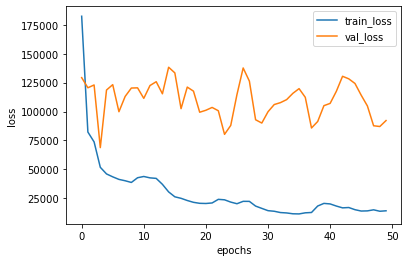

In [103]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## пример чтения сети из файла

In [118]:
#autoencoder_test = vanilla_autoencoder()
with torch.no_grad():
    autoencoder_test = torch.load('vanilla_auoencoder_00.pkl')
    autoencoder_test = autoencoder_test.to('cpu')
    for i, X_batch in enumerate(value_data):
        X_batch['profile'] = X_batch['profile'].to('cpu')
        reconstructed, embadding = autoencoder_test( X_batch['profile'] )
        loss = L(reconstructed, X_batch['profile'])
        #loss = L(reconstructed, X_batch[:, :(len(X_batch[0])-1)], embadding[:, :(len(embadding[0])-1)])
        if i==0:
            embaddings = customdataset(embadding, X_batch['ID'].copy())
            truth = customdataset(X_batch['profile'], X_batch['ID'].copy())
            pred = customdataset(reconstructed, X_batch['ID'].copy())
        else:
            embaddings.profile = torch.cat((embaddings.profile, embadding), 0)
            embaddings.name[len(embaddings.name):] = X_batch['ID']
            pred.profile = torch.cat((pred.profile, reconstructed), 0)
            pred.name[len(pred.name):] = X_batch['ID']
            truth.profile = torch.cat((truth.profile, X_batch['profile']), 0)
            truth.name[len(truth.name):] = X_batch['ID']
print(loss)
print(embaddings)

tensor(4.9312e-05)


## heat map

построение heat map, она показывает расстояние между средними векторами для каждой группы бактерий, на диагонали стоят средне-групповые расстояния 

In [12]:
def euclid (x):
    x = x**2
    l = np.sum(x)
    l = np.sqrt(l)
    return l

In [17]:
embaddings_heat = pd.DataFrame(embaddings[:]['profile'].numpy(), dtype = float)
print(len(embaddings[:]['ID']))
embaddings_heat['50'] = embaddings[:]['group'] 
embaddings_heat_mean = embaddings_heat.groupby('50').mean()
heat_map = np.zeros((len(embaddings_heat_mean.index), len(embaddings_heat_mean.index)))
heat_map = pd.DataFrame(heat_map, index=embaddings_heat_mean.index, 
                        columns=embaddings_heat_mean.index, dtype = float)
for i in embaddings_heat_mean.index:

    #для каждой группы ищем средне-групповое расстояние (ищем разность каждого ветора с каждым и делим на количество разностей) 
    mean = embaddings_heat.loc[embaddings_heat['50'] == i].drop(columns = ['50'], axis=1).to_numpy()
    s = np.zeros((len(mean[0])))
    count = 0
    for j in range (len(mean[:, 0])):
        for k in range (j+1, len(mean[:, 0])):
            s = s + mean[j] - mean[k]
            count = count + 1
    s = s/count
    e = euclid(s)
    heat_map.at[i, i] = e

    #ищем расстояние до средних векторов остальных групп mylist.index(element)
    for j in embaddings_heat_mean.index.values[np.where(embaddings_heat_mean.index.values == i)[0][0]: ]:
        s = embaddings_heat_mean.loc[i].to_numpy() - embaddings_heat_mean.loc[j].to_numpy()       
        e = euclid(s)
        heat_map.at[i, j] = e
print(heat_map.shape)    

7400
(20, 20)


полученная ранее матрица - верхне-треугольная, поэтому транспонируем ее, зануляем диагональ и складываем эти две матрицы

In [20]:
heat_map_t = heat_map.values.copy()
for i in range (len(heat_map['Bacillus_licheniformis'])):
    heat_map_t[i, i] = 0
heat_map_t = heat_map_t.transpose()                  
heat_map.loc[ : , : ] = heat_map.values + heat_map_t     

рисуем heat map

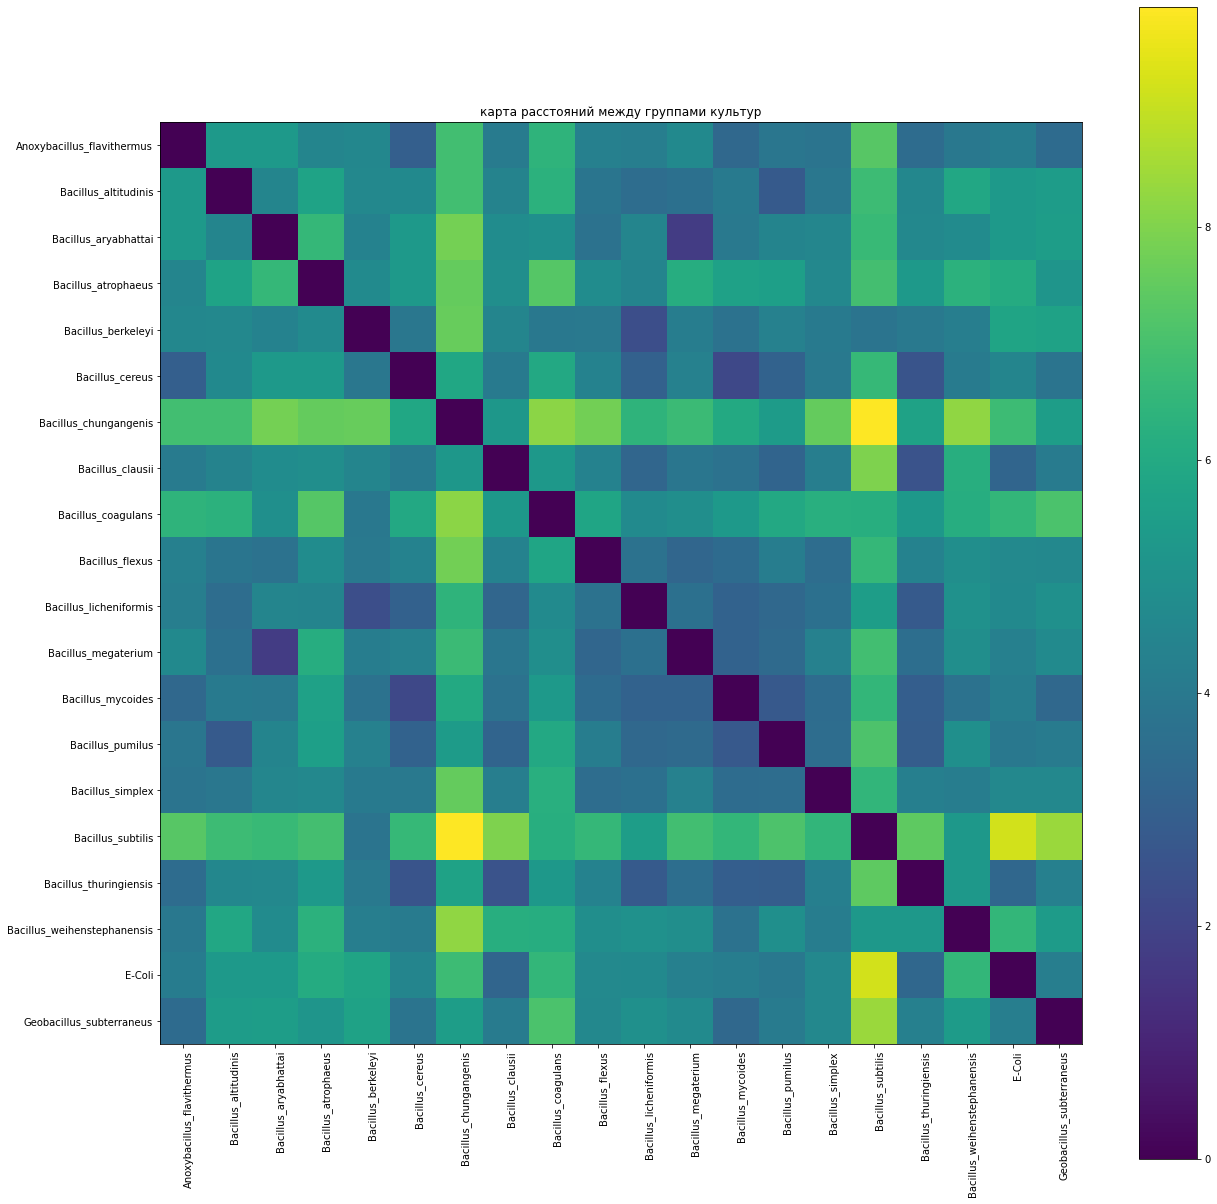

In [21]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks(np.arange(heat_map.shape[1]))
ax.set_yticks(np.arange(heat_map.shape[0]))
ax.set_xticklabels(heat_map)
ax.set_yticklabels(heat_map)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
im = ax.imshow(heat_map)
ax.set_title("карта расстояний между группами культур")
cbar = ax.figure.colorbar(im)
plt.show()

In [88]:
x_train, x_test, y_train, y_test = train_test_split (embaddings[:]['profile'], 
                                                     embaddings[:]['group'], train_size = 0.7)

In [89]:
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

RandomForestClassifier()

In [90]:
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  5  0  0 24  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  2  0  0  4  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  1  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  7  1  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0 10  0  0  0  0  0  0]
 [ 0  7  0  0  0  1  0  0  0  0  6  0  0 26  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  3  0  0 16  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  9  0  0 40  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  4  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0

C:\Users\mishs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mishs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mishs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# VAE
пока забракован


In [91]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(12001, 7000),
            nn.ReLU(),
            nn.Linear(7000, 4000),
            nn.ReLU(),
            nn.Linear(4000, 750),
            nn.ReLU(),
            nn.Linear(750, 100),
            nn.ReLU()
            )

        self.decoder = nn.Sequential(
            nn.ReLU(), 
            nn.Linear(50, 750),
            nn.ReLU(),
            nn.Linear(750, 4000),
            nn.ReLU(), 
            nn.Linear(4000, 7000),
            nn.ReLU(),
            nn.Linear(7000, 12001)
            )

        
    def gaussian_sampler(self, xx):
        m = xx[ : , :50] #полученное матожидание перед скрытым слоем 
        log = xx[ : , 50:] #полученный логарифм дисперсии в квадрате 
        #if self.training:
        sigma = torch.exp(0.5 * log) 
        N = torch.randn_like(sigma) 
        sample = m + (N * sigma) # создаем вектор скрытого состояния
        return sample, m, log
#         else: 
#             sample = m
#             return sample, m, log #на валидации, берем не случайный вектор с такими матожиданием и диссперсией а средний

    def forward(self, x):
        x = self.encoder(x)
        em, mu_f, logsigma_f = self.gaussian_sampler(x)
        reconstruction = self.decoder(em)
        return reconstruction, em, mu_f, logsigma_f

In [92]:
def L (rec, real, m, log):
    los=F.mse_loss(real, rec)+(-0.5 * torch.sum(1 + log - m ** 2 - log.exp()))
    return los  
autoencoder = VAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [93]:
from torch.cuda.memory import list_gpu_processes
n_epochs = 20
train_losses = []
val_losses = []
embaddings = torch.Tensor()
truth = torch.Tensor()
pred = torch.Tensor()

for epoch in tqdm(range(n_epochs)): #tqdm для красивой загрузочки
    autoencoder.train()
    train_losses_per_epoch = []
    for X_batch in train_data:
        X_batch['profile'] = X_batch['profile'].to(device)
        optimizer.zero_grad()
        reconstructed, embadding, mu, logsigma  = autoencoder.forward(X_batch['profile'])
        loss = L(reconstructed, X_batch['profile'], mu, logsigma)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for i, X_batch in enumerate(value_data):
            X_batch['profile'] = X_batch['profile'].to(device)
            reconstructed, embadding, mu, logsigma  = autoencoder(X_batch['profile'])
            loss = L(reconstructed, X_batch['profile'], mu, logsigma)
            val_losses_per_epoch.append(loss.item())
            if epoch == n_epochs - 1:
                embadding = embadding.to('cpu')
                reconstructed = reconstructed.to('cpu')
                X_batch['profile'] = X_batch['profile'].to('cpu')
                if i==0:
                    embaddings = customdataset(embadding, X_batch['group'].copy(), X_batch['ID'].copy())
                    truth = customdataset(X_batch['profile'], X_batch['group'].copy(), X_batch['ID'].copy())
                    pred = customdataset(reconstructed, X_batch['group'].copy(), X_batch['ID'].copy())
                else:
                    embaddings.cat(embadding, X_batch['group'], X_batch['ID'])
                    pred.cat(reconstructed, X_batch['group'], X_batch['ID'])
                    truth.cat(X_batch['profile'], X_batch['group'], X_batch['ID'])

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/20 [00:00<?, ?it/s]

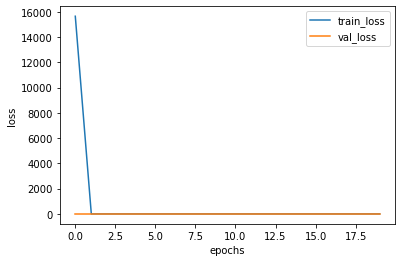

In [94]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [56]:
print(embaddings[:])

{'profile': tensor([[-0.0580, -0.0529,  1.3426,  ..., -0.6304,  0.1741,  0.8791],
        [ 1.1724, -0.7602,  1.7509,  ...,  1.2371,  1.8824,  0.6504],
        [-0.1866, -0.0034,  1.1323,  ..., -0.0798, -2.1678, -1.3434],
        ...,
        [-0.5130, -1.6938, -1.3094,  ...,  1.9922,  1.8420, -0.7178],
        [-0.7292,  2.0430,  1.0188,  ..., -0.2586,  1.1032, -0.4997],
        [ 0.4341, -1.2457, -0.5206,  ..., -2.0810, -0.3330,  0.6404]]), 'group': ['Bacillus_altitudinis', 'Bacillus_cereus', 'Bacillus_simplex', 'Geobacillus_subterraneus', 'Bacillus_megaterium', 'Bacillus_weihenstephanensis', 'Bacillus_cereus', 'Bacillus_megaterium', 'Geobacillus_subterraneus', 'Bacillus_simplex', 'Bacillus_licheniformis', 'Bacillus_chungangenis', 'Bacillus_licheniformis', 'Bacillus_licheniformis', 'Bacillus_megaterium', 'Bacillus_pumilus', 'Bacillus_clausii', 'Bacillus_mycoides', 'Bacillus_altitudinis', 'Bacillus_pumilus', 'Bacillus_simplex', 'Bacillus_pumilus', 'Bacillus_altitudinis', 'Bacillus_lic

# Denoising autoencoder

In [50]:
MS_profiles_set = customdataset (MS_profiles.iloc[:, :12001].to_numpy(),
                                 MS_profiles.iloc[:, 12001].to_numpy(),
                                 MS_profiles.iloc[:, 12002].to_numpy())

In [87]:
MS_profiles_sintes=pd.read_csv("MS_profiles\sets\MS_profiles_sintes_norm_noise_100%_2",\
                               sep=';', index_col=0, header=0)
MS_profiles_test_noise = customdataset (MS_profiles_sintes.iloc[:, :12001].to_numpy(),
                                 MS_profiles_sintes.iloc[:, 12001].to_numpy(),
                                 MS_profiles_sintes.iloc[:, 12002].to_numpy())
MS_profiles_sintes

,3000.0,3001.0,3002.0,3003.0,3004.0,3005.0,3006.0,3007.0,3008.0,3009.0,...,14993.0,14994.0,14995.0,14996.0,14997.0,14998.0,14999.0,15000.0,15001.0,15002.0
0,0.0,0.006989,0.009474,0.011865,0.014919,0.013818,0.014891,0.014112,0.011084,0.013803,...,0.002440,0.002064,0.001836,0.001591,0.001053,0.000658,0.000551,0.0,Bacillus_licheniformis,KUskv2(1)
1,0.0,0.004763,0.009817,0.034881,0.018070,0.005413,0.046530,0.018136,0.011061,0.020801,...,0.002118,0.000053,0.001487,0.002096,0.000371,0.000251,0.000137,0.0,Bacillus_licheniformis,KUskv2(1)
2,0.0,0.012852,0.003425,0.025271,0.009061,0.013747,0.012419,0.019835,0.002492,0.017738,...,0.002677,0.004130,0.002510,0.001092,0.000857,0.000140,0.000058,0.0,Bacillus_licheniformis,KUskv2(1)
3,0.0,0.017205,0.005666,0.012912,0.009946,0.009892,0.036287,0.003361,0.006030,0.015071,...,0.002978,0.001497,0.004651,0.001753,0.000300,0.001533,0.000660,0.0,Bacillus_licheniformis,KUskv2(1)
4,0.0,0.007217,0.001048,0.016819,0.011939,0.025891,0.015581,0.005821,0.005917,0.020402,...,0.008646,0.001010,0.000511,0.003294,0.003341,0.001306,0.000364,0.0,Bacillus_licheniformis,KUskv2(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.0,0.005942,0.002435,0.017605,0.001303,0.005400,0.006719,0.003256,0.000946,0.018397,...,0.000334,0.001311,0.003330,0.001445,0.000406,0.000912,0.000826,0.0,Bacillus_chungangenis,45(3)il
3125,0.0,0.001358,0.003181,0.026081,0.003221,0.012753,0.009940,0.015499,0.009613,0.031066,...,0.002175,0.000290,0.002820,0.001239,0.002242,0.000143,0.000189,0.0,Bacillus_chungangenis,45(3)il
3126,0.0,0.007847,0.008806,0.005308,0.001877,0.012934,0.010689,0.005295,0.012382,0.008236,...,0.000802,0.002467,0.002177,0.001617,0.000338,0.000828,0.000022,0.0,Bacillus_chungangenis,45(3)il
3127,0.0,0.011118,0.000797,0.012318,0.003748,0.002949,0.013608,0.007768,0.021935,0.030092,...,0.000046,0.001611,0.001686,0.000824,0.001633,0.001858,0.000053,0.0,Bacillus_chungangenis,45(3)il


**создаем test и value выборки**

In [51]:
batch_s=16
train, value = train_test_split(MS_profiles_set, train_size=0.7, shuffle=True)#получили value выбороку
train_data = DataLoader(MS_profiles_set, batch_size=batch_s, shuffle=True)#а на train отправляем весь\
#MS_profiles_set что бы модель знала профили всех имеющихся бактерий
value_data = DataLoader(MS_profiles_set, batch_size=batch_s)

**лосс-функция/оптимайзер**

In [52]:
L = F.mse_loss #nn.torch.functional....
autoencoder = vanilla_autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

**тренировка**

In [53]:
from torch.cuda.memory import list_gpu_processes
n_epochs = 100
train_losses = []
val_losses = []
embaddings = torch.Tensor()
truth = torch.Tensor()
pred = torch.Tensor()
noise_factor = 0.4
count = 0

for epoch in tqdm(range(n_epochs)): #tqdm для красивой загрузочки
    autoencoder.train()
    train_losses_per_epoch = []
    for X_batch in train_data:
        noise = X_batch['profile'] + \
        torch.FloatTensor(np.random.normal(loc=0.0, \
                scale=noise_factor*X_batch['profile'], size= list(X_batch['profile'].size())))#шумим
        noise = torch.abs(noise)
        y = torch.ones(list(X_batch['profile'].size()))
        noise = torch.where(noise < 1, noise, y)
        X_batch['profile'] = X_batch['profile'].to(device)#чистые векторы 
        #print(X_batch['profile'].size().numpy())
        noise = noise.to(device)
        #print(noise.max())
        optimizer.zero_grad()
        reconstructed, embadding = autoencoder.forward(noise)#скармливаем шум
        loss = L(reconstructed, X_batch['profile'])#сравниваем с читыми
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for i, X_batch in enumerate(value_data):
            noise = X_batch['profile'] + \
                     torch.FloatTensor(np.random.normal(loc=0.0, \
                      scale=noise_factor*X_batch['profile'], size= list(X_batch['profile'].size())))#шумим
            noise = torch.abs(noise)
            y = torch.ones(list(X_batch['profile'].size()))
            noise = torch.where(noise < 1, noise, y)
            noise = noise.to(device)
            reconstructed, embadding = autoencoder(noise)
            X_batch['profile'] = X_batch['profile'].to(device)
            loss = L(reconstructed, X_batch['profile'])
            val_losses_per_epoch.append(loss.item())
            if (epoch >= (n_epochs - 100)):
                count = count + 1
                embadding = embadding.to('cpu')
                reconstructed = reconstructed.to('cpu')
                X_batch['profile'] = X_batch['profile'].to('cpu')
                if (i==0)and(epoch == n_epochs - 100):
                    embaddings = customdataset(embadding, X_batch['group'].copy(), X_batch['ID'].copy())
                    truth = customdataset(X_batch['profile'], X_batch['group'].copy(), X_batch['ID'].copy())
                    pred = customdataset(reconstructed, X_batch['group'].copy(), X_batch['ID'].copy())
                    embadding = embadding.to(device)
                if (i!=0)or(epoch != n_epochs - 100):    
                    embaddings.cat(embadding, X_batch['group'], X_batch['ID'])
                    pred.cat(reconstructed, X_batch['group'], X_batch['ID'])
                    truth.cat(X_batch['profile'], X_batch['group'], X_batch['ID'])
                    embadding = embadding.to(device)

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
embaddings[:]['profile'].shape

torch.Size([14900, 50])

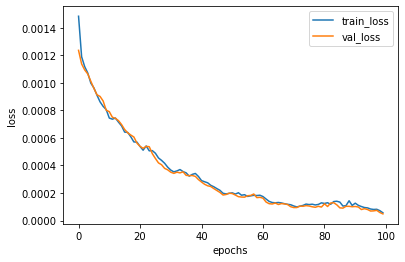

In [55]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [60]:
torch.save (nn.Sequential(autoencoder.encoder, autoencoder.fc), 'DAE_norm_noise_40%.pkl')

In [61]:
classifier_group = RandomForestClassifier()
classifier_ID = RandomForestClassifier()
classifier_group.fit(embaddings[:]['profile'], embaddings[:]['group'])
classifier_ID.fit(embaddings[:]['profile'], embaddings[:]['ID'])

RandomForestClassifier()

## сохраним лес

In [62]:
with open('forest_norm_noise_40%_group', 'wb') as f:
    pickle.dump(classifier_group, f)

In [63]:
with open('forest_norm_noise_40%_ID', 'wb') as f:
    pickle.dump(classifier_ID, f)

*прочитаем его*

In [85]:

with open('forest_norm_noise_100%_group', 'rb') as f:
    classifier = pickle.load(f)

In [90]:
pred = classifier.predict(embaddings[:]['profile']) 
print(confusion_matrix(embaddings[:]['group'], pred))
print(classification_report(embaddings[:]['group'], pred))

[[ 42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 386   0   0   0   0   0   0   0   0  12   0   0   1   0   0   0   0
    0   0]
 [  0   0  42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  84   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0  42   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0 336   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0  42   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0  42   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0  42   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0  84   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 441   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 252   0   0   0   0

## Инференс

In [32]:
confusion_noise_group = pd.DataFrame(np.zeros((5, 6)), columns = np.hstack((np.array(['input_noise_0%']),\
                                                np.array(['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)]))), index = ['train_noise_'+str(j)+'%' for j in range(10, 35, 5)])
confusion_noise_ID = pd.DataFrame(np.zeros((5, 6)), columns = np.hstack((np.array(['input_noise_0%']),\
                                                        np.array(['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)]))), index = ['train_noise_'+str(j)+'%' for j in range(10, 35, 5)])
s_group = pd.DataFrame(np.zeros((4, 5)), columns = ['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)], index = ['train_noise_'+str(j)+'%' for j in range(40, 120, 20)])
s_ID = pd.DataFrame(np.zeros((4, 5)), columns = ['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)], index = ['train_noise_'+str(j)+'%' for j in range(40, 120, 20)])
confusion_noise_group = confusion_noise_group.append(s_group)
confusion_noise_ID = confusion_noise_ID.append(s_ID)
for j in range (40, 120, 20):
    confusion_noise_ID['input_noise_'+str(j)+'%']  = np.zeros((9))
    confusion_noise_group['input_noise_'+str(j)+'%']  = np.zeros((9))
for j in range (100, 350, 50):
    confusion_noise_ID['input_noise_'+str(j)+'%']  = np.zeros((9))
    confusion_noise_group['input_noise_'+str(j)+'%']  = np.zeros((9))
confusion_noise_ID                                


,input_noise_0%,input_noise_10%,input_noise_15%,input_noise_20%,input_noise_25%,input_noise_30%,input_noise_40%,input_noise_60%,input_noise_80%,input_noise_100%,input_noise_150%,input_noise_200%,input_noise_250%,input_noise_300%
train_noise_10%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_15%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_20%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_30%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_40%,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_60%,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_80%,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_100%,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
confusion_noise_group = pd.DataFrame(np.zeros((5, 6)), columns = np.hstack((np.array(['input_noise_0%']),\
                                                np.array(['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)]))), index = ['train_noise_'+str(j)+'%' for j in range(10, 35, 5)])
confusion_noise_ID = pd.DataFrame(np.zeros((5, 6)), columns = np.hstack((np.array(['input_noise_0%']),\
                                                        np.array(['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)]))), index = ['train_noise_'+str(j)+'%' for j in range(10, 35, 5)])
s_group = pd.DataFrame(np.zeros((1, 5)), columns = ['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)], index = ['train_noise_40%'])
s_ID = pd.DataFrame(np.zeros((1, 5)), columns = ['input_noise_'+str(j)+'%'\
    for j in range(10, 35, 5)], index = ['train_noise_40%'])
confusion_noise_group = confusion_noise_group.append(s_group)
confusion_noise_ID = confusion_noise_ID.append(s_ID)
for i in range(40, 120, 20):
    confusion_noise_group['input_noise_'+str(i)+'%'] = np.zeros((6))
    confusion_noise_ID['input_noise_'+str(i)+'%'] = np.zeros((6))
for i in range(150, 350, 50):    
    confusion_noise_group['input_noise_'+str(i)+'%'] = np.zeros((6))
    confusion_noise_ID['input_noise_'+str(i)+'%'] = np.zeros((6))
confusion_noise_group_acc = confusion_noise_group.copy()
confusion_noise_ID_acc = confusion_noise_ID.copy()
confusion_noise_group

,input_noise_0%,input_noise_10%,input_noise_15%,input_noise_20%,input_noise_25%,input_noise_30%,input_noise_40%,input_noise_60%,input_noise_80%,input_noise_100%,input_noise_150%,input_noise_200%,input_noise_250%,input_noise_300%
train_noise_10%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_15%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_20%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_30%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
train_noise_40%,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#index_i = np.array(['10%', '15%', '20%', '25%', '30%', '40%'])
index_i = np.array(['40%'])
index_j = np.hstack((np.array(['0%', '10%', '15%', '20%', '25%', '30%']),\
                    np.array([str(i)+'%' for i in range(40, 120, 20)])))
index_j = np.hstack((index_j, np.array([str(i)+'%' for i in range(150, 350, 50)])))
for i in tqdm(index_i):
    autoencoder_inference = torch.load('DAE_norm_noise_'+str(i)+'.pkl')
    with open('forest_norm_noise_'+str(i)+'_group', 'rb') as f:
        classifier_group = pickle.load(f)
    with open('forest_norm_noise_'+str(i)+'_ID', 'rb') as f:
        classifier_ID = pickle.load(f)        
#     for j in np.hstack((index, np.array(['0%']))):
    for j in tqdm(index_j):             
        #энкодер
        MS_profiles_inference=pd.read_csv("MS_profiles\sets\MS_profiles_sintes_norm_noise_"\
                            +str(j)+"_inference_2",sep=';', index_col=0, header=0)
        MS_profiles_inference = MS_profiles_inference.astype({'15002.0': 'str'})
        MS_profiles_inference_set = customdataset (MS_profiles_inference.iloc[:, :12001].to_numpy(),
                                         MS_profiles_inference.iloc[:, 12001].to_numpy(),
                                         MS_profiles_inference.iloc[:, 12002].to_numpy())
        with torch.no_grad():
            autoencoder_inference = autoencoder_inference.to('cpu')
#             value_loader = DataLoader(MS_profiles_inference_set, batch_size = \
#                                       len(MS_profiles_inference_set), shuffle = True)
#             print(type(value_loader))
#             for q in value_loader: 
#                 print(q['profile'])
            embaddings_inference = autoencoder_inference( MS_profiles_inference_set[:]['profile'] )
            embaddings_inference = customdataset(embaddings_inference, \
                MS_profiles_inference_set[:]['group'].copy(), MS_profiles_inference_set[:]['ID'].copy())   
        #дерево для групп
        pred_group = classifier_group.predict(embaddings_inference[:]['profile'])
        report_group = classification_report(embaddings_inference[:]['group'],\
                                             pred_group, output_dict=True)
        confusion_noise_group_acc.at ['train_noise_'+str(i), 'input_noise_'+str(j)] = \
                                                               report_group['accuracy']
        report_group = pd.DataFrame(report_group).transpose() 
        if i == j:
            report_group.to_csv(r"classification_result_norm_noise_"+str(i)+"_group_2.csv", sep=';',\
                                                                               header=True, index=True,) 
        report_group = report_group.drop(index = ['accuracy', 'macro avg', 'weighted avg'], axis = 0)
        confusion_noise_group.at ['train_noise_'+str(i), 'input_noise_'+str(j)] = \
                                                               report_group.mean()['f1-score']
        #дерево для штаммов
        embaddings_inference[:]['ID'][embaddings_inference[:]['ID'].dtype == 'int'] = \
                        str(embaddings_inference[:]['ID'][embaddings_inference[:]['ID'].dtype == 'int'])
        pred_ID = classifier_ID.predict(embaddings_inference[:]['profile'])
        pred_ID[pred_ID.dtype == 'int'] =  str(pred_ID[pred_ID.dtype == 'int'])
        report_ID = classification_report(embaddings_inference[:]['ID'], pred_ID, output_dict=True)
        confusion_noise_ID_acc.at ['train_noise_'+str(i), 'input_noise_'+str(j)] = \
                                                               report_ID['accuracy']
        report_ID = pd.DataFrame(report_ID).transpose()
        if i == j:
            report_ID.to_csv(r"classification_result_norm_noise_"+str(i)+"_ID.csv", sep=';',\
                                                                         header=True, index=True,)
        report_ID = report_ID.drop(index = ['accuracy', 'macro avg', 'weighted avg'], axis = 0)
        confusion_noise_ID.at ['train_noise_'+str(i), 'input_noise_'+str(j)] = report_ID.mean()['f1-score']

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [13]:
autoencoder_inference = torch.load('DAE_norm_noise_40%.pkl')
MS_profiles_inference=pd.read_csv("MS_profiles\sets\MS_profiles_sintes_norm_noise_40%_inference_2",sep=';', index_col=0, header=0)
MS_profiles_inference = MS_profiles_inference.astype({'15002.0': 'str'})
MS_profiles_inference_set = customdataset (MS_profiles_inference.iloc[:, :12001].to_numpy(),
                                 MS_profiles_inference.iloc[:, 12001].to_numpy(),
                                 MS_profiles_inference.iloc[:, 12002].to_numpy())
with torch.no_grad():
    autoencoder_inference = autoencoder_inference.to('cpu')
    embaddings = autoencoder_inference( MS_profiles_inference_set[:]['profile'] )
#     embaddings = np.concatenate((embaddings.numpy(),\
#                 np.transpose(np.array([MS_profiles_inference_set[:]['group'].copy()]))), axis = 1)
#     embaddings = np.concatenate((embaddings,\
#                 np.transpose(np.array([MS_profiles_inference_set[:]['ID'].copy()]))), axis = 1)
embaddings = customdataset(embaddings, \
                MS_profiles_inference_set[:]['group'].copy(), MS_profiles_inference_set[:]['ID'].copy())  

In [66]:
confusion_noise_group

,input_noise_0%,input_noise_10%,input_noise_15%,input_noise_20%,input_noise_25%,input_noise_30%,input_noise_40%,input_noise_60%,input_noise_80%,input_noise_100%,input_noise_150%,input_noise_200%,input_noise_250%,input_noise_300%
train_noise_10%,0.0,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
train_noise_15%,0.0,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
train_noise_20%,0.0,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
train_noise_25%,0.0,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
train_noise_30%,0.0,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
train_noise_40%,1.0,0.999378,0.999,0.930299,0.934245,0.86199,0.840844,0.806712,0.8017,0.734973,0.595038,0.556913,0.413108,0.354568


In [67]:
#сохраним таблицы
confusion_noise_group.to_csv(r"confusion_noise_group_40%.csv", sep=';', header=True, index=True,)
confusion_noise_ID.to_csv(r"confusion_noise_ID_40%.csv", sep=';', header=True, index=True,)
# confusion_noise_group_acc.to_csv(r"confusion_noise_group_final_acc.csv", sep=';', header=True, index=True,)
# confusion_noise_ID_acc.to_csv(r"confusion_noise_ID_final_acc.csv", sep=';', header=True, index=True,)

In [47]:
#транспонирование для душнилы
indexes = np.hstack((np.array(0), np.array([i for i in range (10, 35, 5)])))
indexes = np.hstack((indexes, np.array([i for i in range (40, 120, 20)])))
indexes = np.hstack((indexes, np.array([i for i in range (150, 350, 50)])))
for i in indexes:
    transpose = pd.read_csv("MS_profiles\sets\MS_profiles_sintes_norm_noise_"+str(i)+"%_inference_2",\
                               sep=';', index_col=0, header=0)
    transpose = transpose.transpose()
    copy = transpose.copy().to_numpy()
    copy1 = copy[12001:, :]
    copy = np.vstack((copy1, copy))
    copy = pd.DataFrame(copy[:12003, :], index = np.hstack((np.array(['group', 'ID']),\
                      transpose.index.to_numpy()[:12001])),\
                        columns = transpose.columns)
    copy.to_csv(r"MS_profiles\sets\MS_profiles_sintes_norm_noise_"+str(i)+"%_inference_4.csv", sep=';',\
                                                                               header=True, index=True,) 
    

# анализ пиков

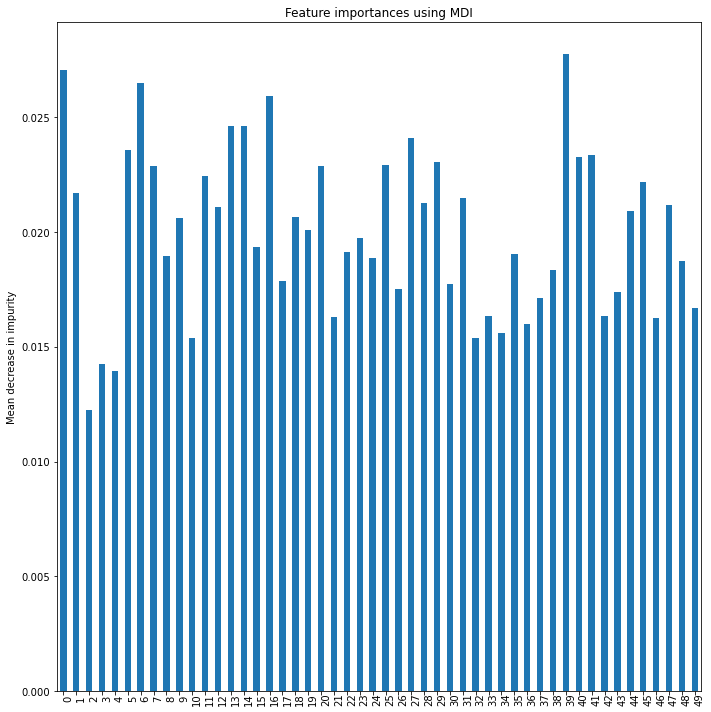

In [43]:
with open('forest_norm_noise_40%_ID', 'rb') as f:
        classifier_group = pickle.load(f)
importances = classifier_group.feature_importances_
forest_importances = pd.Series(importances, index={i for i in range (len(embaddings_inference[0]['profile']))})
std = np.std([tree.feature_importances_ for tree in classifier_group.estimators_], axis=0) #deviation - мера распределения
fig, ax = plt.subplots(figsize=(10,10))
#fig = plt.figure(figsize=(20,20))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.setp(ax.get_xticklabels(), rotation=90, rotation_mode="anchor")
fig.tight_layout()

In [44]:
top = forest_importances.nlargest(10)
J = np.zeros(len(top.index)) # массив для хранения индексов макимальных весов 
#ищем максимумы между 3 и 4 слоями енкодера
for j, i in enumerate(top.index):
    maximum, J[j] = torch.max(autoencoder_inference[1].weight[i], dim = 0)
print(J)
#ищем максимумы между 2 и 3 слоями енкодера
for j in range(len(J)):
    maximum, J[j] = torch.max((autoencoder_inference[0][2]).weight[int(J[j])], dim = 0)
print(J)
#ищем максимумы между 1 и 2 слоями енкодера
mz_features = np.array([], dtype = int)
for j in range(len(J)):
    current = (autoencoder_inference[0][0]).weight[int(J[j])]
    #beta = random.uniform(1, 2.5)
    beta = 5
    T = torch.mean(current) + beta*torch.std(current)
    for i in range(len((autoencoder_inference[0][0]).weight[0])):
        if (autoencoder_inference[0][0]).weight[int(J[j]), i] >= float(T):
            mz_features = np.append(mz_features, i)
print (len(mz_features))
print(mz_features)                  

[ 67. 466. 466. 126. 573. 190. 221. 573. 113.  85.]
[3734. 5780. 5780. 4034. 4550.  321. 2017. 4550. 2894. 2177.]
311
[ 626  765  766  767  768  769 1379 1380 2201 2202 2203 2204 2205 2207
 2208 2209 2210 2212 2213 2214 2215 2217 2231 2232 2313 2551 2552 2982
 2983 2984 2985 2986 2987 2989 2990 2991 3110 3111 3112 3113 3114 3115
 3118 3119 3120 3121 3122 3123 3124 3125 3155 3156 3158 3159 3160 3162
 3886 3887 3888 3889 3890 3891 3892 4251 4252 3246 3254 3255 3256 3257
 3258 3259 3260 3261 3263 3268 3443 3559 3563 3564 3566 3567 3568 3569
 3570 3571 3572 3246 3254 3255 3256 3257 3258 3259 3260 3261 3263 3268
 3443 3559 3563 3564 3566 3567 3568 3569 3570 3571 3572  713  429  557
 1801 1960 1961 3261 3263 3267 3268 3270 4139 4141 4142 4143 4155 4156
 4158 4159 4160 4162 4361 4363 4364 4365 4367 4368 4369 4370 4371 4372
 4373 4392 4393 4394 4395 4396 4397 4398 4399 4822 6603 6604 6607  133
  557  558  560  562 2211 2893 2894 2895 2987 2989 3255 3256 3257 3258
 3259 3260 3261 3262 3263 3264

In [45]:
mz_features = np.unique(mz_features) + 3000
print (len(mz_features))
print (mz_features)

216
[3023 3025 3026 3027 3033 3034 3035 3036 3133 3429 3436 3437 3438 3439
 3440 3557 3558 3560 3562 3609 3610 3611 3612 3613 3615 3616 3623 3624
 3626 3627 3628 3629 3630 3713 3765 3766 3767 3768 3769 3922 4379 4380
 4801 4862 4865 4960 4961 5201 5202 5203 5204 5205 5206 5207 5208 5209
 5210 5211 5212 5213 5214 5215 5217 5231 5232 5313 5445 5551 5552 5836
 5838 5839 5840 5841 5842 5843 5844 5845 5846 5847 5848 5849 5850 5851
 5853 5893 5894 5895 5896 5898 5899 5917 5918 5982 5983 5984 5985 5986
 5987 5989 5990 5991 6041 6043 6044 6110 6111 6112 6113 6114 6115 6118
 6119 6120 6121 6122 6123 6124 6125 6155 6156 6158 6159 6160 6162 6246
 6254 6255 6256 6257 6258 6259 6260 6261 6262 6263 6264 6265 6267 6268
 6269 6270 6443 6559 6563 6564 6566 6567 6568 6569 6570 6571 6572 6840
 6863 6864 6886 6887 6888 6889 6890 6891 6892 6895 7139 7141 7142 7143
 7155 7156 7158 7159 7160 7162 7251 7252 7255 7256 7259 7260 7262 7285
 7286 7287 7288 7289 7290 7291 7292 7361 7363 7364 7365 7367 7368 7369
 7

In [93]:
np.save('mz_features_group', mz_features)

In [46]:
np.savetxt('mz_features_ID_40%_txt', mz_features, fmt='%d')